# May 30, 2022: Data samples and model
get data samples from MAX dataset. A sample is a 14TRs time series for a trial: threat/safe.

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp

import torch
import torch.nn as nn 
print(torch.cuda.is_available())

import pickle, time, random
# import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations, product
from operator import add
import copy
from glob import glob

# explanation tools
import captum

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jun22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils
import helpers.base_model as base_model
import helpers.model_definitions as model_definitions

True


2022-06-01 21:09:03.925066: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:1 device


## dataset

In [3]:
def get_data(data_df, subj_idx_list):
    normalize = lambda z: (z - np.mean(z)) / np.std(z)

    X, y = [], []
    for idx_row in tqdm(subj_idx_list):
        subj, ts, targets = data_df.iloc[idx_row]

        for label in args.LABELS:
            contig_regions = dataset_utils.contiguous_regions(targets == label)

            for region in contig_regions:
                X.append(ts[region[0]: region[1], :])
                y.append(targets[region[0]: region[1]])

    X = np.stack(X, axis=0)
    y = np.stack(y, axis=0)

    for idx_roi in np.arange(X.shape[-1]):
        X[:, :, idx_roi] = normalize(np.squeeze(X[:, :, idx_roi]))
    
    return torch.FloatTensor(X).to(device=device), torch.LongTensor(y).to(device=device)

In [4]:
'''
dataframe
'''
max_data_path = f"{proj_dir}/data/max/data_df.pkl"
with open(max_data_path, 'rb') as f:
    max_data_df = pickle.load(f)

'''
(hyper)-parameters
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74
args.LABELS = [0, 1]
args.names = ['safe', 'threat']
args.MASK = -100

# data
args.num_subjects = len(max_data_df)
args.num_train = round(0.4 * args.num_subjects)
args.num_valid = round(0.3 * args.num_subjects)
args.num_test = args.num_subjects - args.num_train - args.num_valid

'''
generate dataset for the model
'''
subject_idx_list = np.arange(args.num_subjects)
# random.Random(args.SEED).shuffle(subject_idx_list)

train_idx_list = subject_idx_list[:args.num_train]
valid_idx_list = subject_idx_list[args.num_train : args.num_train + args.num_valid]
test_idx_list = subject_idx_list[args.num_train + args.num_valid:]

(X_train, y_train) = get_data(max_data_df, train_idx_list)
(X_valid, y_valid) = get_data(max_data_df, valid_idx_list) 
(X_test, y_test) = get_data(max_data_df, test_idx_list)

100%|██████████| 32/32 [00:00<00:00, 4220.68it/s]


In [5]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

torch.Size([1336, 14, 85]) torch.Size([1336, 14])
torch.Size([1016, 14, 85]) torch.Size([1016, 14])
torch.Size([974, 14, 85]) torch.Size([974, 14])


In [1]:
def plot_roi_time_series(X, y, fig_file=None, savefig=True):
    X_conds = {}
    for label in args.LABELS:
        idx = y[:, 0] == label
        X_conds[f"{label}_m"] = np.mean(X[idx, :, :], axis=0)
        X_conds[f"{label}_s"] = 1.96 * np.std(X[idx, :], axis=0) / np.sqrt(idx.shape[0])

    roi_name_file = (
        f"{os.environ['HOME']}/parcellations/MAX_85_ROI_masks/ROI_names.txt"
    )
    roi_names = pd.read_csv(roi_name_file, names=['roi_name']).values.squeeze()

    time = np.arange(X.shape[1])
    names = ['safe', 'threat']
    colors = {0:'royalblue', 1:'firebrick'}
    nrows, ncols = 17, 5

    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=True, 
        dpi=150
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    for idx_roi, roi_name in enumerate(roi_names):
        ax = axs[idx_roi//ncols, np.mod(idx_roi,ncols)]

        ax.set_title(f"{roi_name}")
        for label in args.LABELS:
            ts_mean = X_conds[f"{label}_m"][:, idx_roi]
            ts_std = X_conds[f"{label}_s"][:, idx_roi]

            ax.plot(ts_mean, color=colors[label], label=names[label])

            ax.fill_between(
                time, 
                (ts_mean - ts_std), 
                (ts_mean + ts_std),
                alpha=0.3, color=colors[label],
            )
        ax.set_xlabel(f"time")
        ax.set_ylabel(f"roi resp.")
        ax.grid(True)
        ax.legend()

    if savefig:
        fig.savefig(
            fig_file,
            dpi=150,
            format='png',
            bbox_inches='tight',
            transparent=False
        )

In [7]:
# fig_file = f"{proj_dir}/data/max/roi_timeseries_train.png"
# X, y = X_train.cpu().numpy(), y_train.cpu().numpy()
# plot_roi_time_series(X, y, fig_file)

# fig_file = f"{proj_dir}/data/max/roi_timeseries_valid.png"
# X, y = X_valid.cpu().numpy(), y_valid.cpu().numpy()
# plot_roi_time_series(X, y, fig_file)


I compared the time series of each roi with the responses shown in the MAX paradigm paper: [Murty et al. - 2022 - Distributed and Multifaceted Effects of Threat and Safety](https://direct.mit.edu/jocn/article/34/3/495/108894).
They are comparable justifying the correctness of this extracted time series for further analysis.

## model

In [8]:
def plot_training_history(history):
    fig, axs = plt.subplots(
        nrows=2, ncols=1,
        figsize=(11,5),
        dpi=150
    )

    ax = axs[0]
    ax.plot(history['train_loss'], color='tomato', linestyle='-.', label='training_loss')
    ax.plot(history['valid_loss'], color='forestgreen', label='valid_loss')
    ax.set_ylabel(f"losses")
    ax.set_xlabel(f"epochs")
    ax.legend()
    ax.grid(True)

    ax = axs[1]
    ax.plot(history['train_acc'], color='tomato', linestyle='-.', label='training_acc')
    ax.plot(history['valid_acc'], color='forestgreen', label='valid_acc')
    ax.set_ylabel(f"accuracies")
    ax.set_xlabel(f"epochs")
    ax.set_ylim(0.5, 1.0)
    ax.legend()
    ax.grid(True)

In [9]:
def train(model, X, y, opt, loss_obj, permutation):
    epoch_losses = []
    epoch_accs = []

    model.train()

    for i in range(0, X.size()[0], args.batch_size):
        indices = permutation[i:i + args.batch_size]
        batch_x, batch_y = X[indices], y[indices]

        y_pred = model(batch_x,)
        loss = loss_obj(
            y_pred.view(-1, args.num_classes), 
            batch_y.view(-1)
        )

        acc = model.accuracy(y_pred, batch_y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_losses += [loss.item()]
        epoch_accs += [acc.item()]

    return  np.sum(epoch_losses) / len(epoch_losses), np.sum(epoch_accs) / len(epoch_accs)


def evaluate(model, X, y, loss_obj, permutation):
    epoch_losses = []
    epoch_accs = []

    model.eval()

    with torch.no_grad():
        for i in range(0, X.size()[0], args.batch_size):
            indices = permutation[i:i + args.batch_size]
            batch_x, batch_y = X[indices], y[indices]

            y_pred = model(batch_x,)
            loss = loss_obj(
                y_pred.view(-1, args.num_classes), 
                batch_y.view(-1)
            )

            acc = model.accuracy(y_pred, batch_y)

            epoch_losses += [loss.item()]
            epoch_accs += [acc.item()]
    
    return np.sum(epoch_losses) / len(epoch_losses), np.sum(epoch_accs) / len(epoch_accs)

In [10]:
def fit(model, loss_obj, optimizer):
    best_valid_loss = float('inf')

    train_loss, train_acc = np.zeros(args.num_epochs), np.zeros(args.num_epochs)
    valid_loss, valid_acc = np.zeros(args.num_epochs), np.zeros(args.num_epochs)

    for epoch in range(args.num_epochs):
        train_loss[epoch], train_acc[epoch] = train(model, X_train, y_train, optimizer, loss_obj, permut_train)
        valid_loss[epoch], valid_acc[epoch] = evaluate(model, X_valid, y_valid, loss_obj, permut_valid)

        if valid_loss[epoch] < best_valid_loss:
            best_valid_loss = valid_loss[epoch]
            torch.save(model.state_dict(), model_file)
        
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

    history = {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'valid_loss': valid_loss,
        'valid_acc': valid_acc
    }

    # torch.save(model.state_dict(), model_file)
    with open(history_file, 'wb') as f:
        pickle.dump(history, f)

In [11]:
# model args
args.num_classes = 2 # for binary classification
args.l2 = 1e-2
args.dropout = 0.5
args.learning_rate = 4e-4

args.num_epochs = 50
args.validation_split = 0.2
args.batch_size = 64

args.return_sequences = True

args.input_size = X_train.shape[-1]

In [12]:
class GRU_classifier(nn.Module):
    def __init__(self, args):
        super(GRU_classifier, self).__init__()

        self.gru = nn.GRU(
            input_size=args.input_size,
            hidden_size=args.num_units,
            num_layers=1,
            batch_first=True,
            dropout=args.dropout
        )
        
        self.fc = nn.Linear(args.num_units, args.num_classes)

        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x):
        x, hn = self.gru(x)
        x = self.dropout(x)
        y = self.fc(x)
        return y

    # def initHidden(self, args):
        # return torch.zeros(1, args.batch_size, args.num_units, device=device)

    def accuracy(self, y_pred, y_true):
        labels_pred = torch.argmax(y_pred, axis=-1)
        mask = (y_true != args.MASK).bool()
        correct = 1-torch.abs(labels_pred[mask] - y_true[mask])
        return correct.sum() / len(correct)

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


(0.6300452649593353, 0.640365943312645)
(0.6605154164135456, 0.6018515080213547)


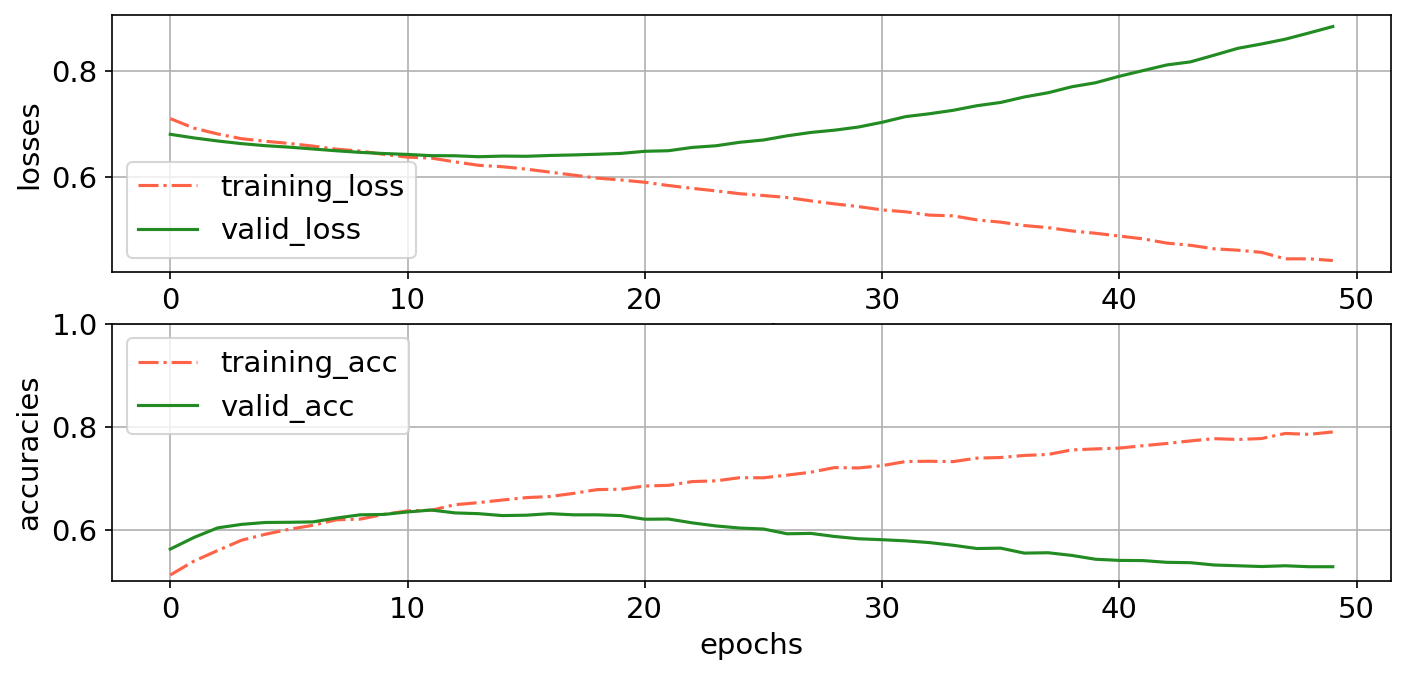

In [13]:
args.num_units = 8
model_file = f"{results_dir}/max/models/GRU_classifier_gruunits_{args.num_units}.pt"
history_file = f"{results_dir}/max/models/GRU_classifier_gruunits_{args.num_units}_history"

model = GRU_classifier(args).to(torch.float32)
loss_obj = nn.CrossEntropyLoss(ignore_index=args.MASK, reduction='mean')
optimizer = torch.optim.Adam(model.parameters())

model.to(device)
loss_obj.to(device)

# X_train, y_train, X_valid, y_valid, model_file, history_file
permut_train = torch.randperm(X_train.size()[0])
permut_valid = torch.randperm(X_valid.size()[0])

if not os.path.exists(model_file):
    fit(model, loss_obj, optimizer)


model.load_state_dict(torch.load(model_file))
with open(history_file, 'rb') as f:
    history = pickle.load(f)

plot_training_history(history)

print(evaluate(model, X_valid, y_valid, loss_obj, permut_valid))

permut_test = torch.randperm(X_test.size()[0])
print(evaluate(model, X_test, y_test, loss_obj, permut_test))

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


(0.6259980648756027, 0.6399274803698063)
(0.6607323251664639, 0.6029077917337418)


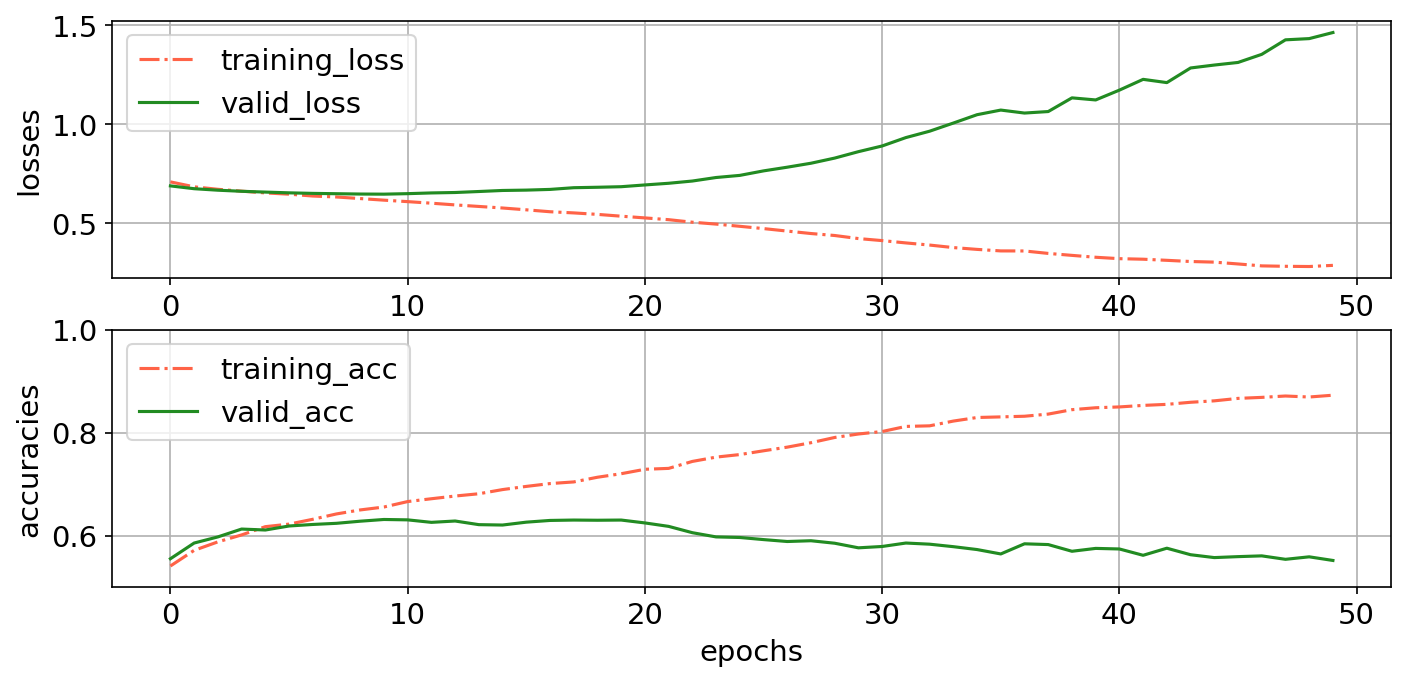

In [14]:
args.num_units = 16
model_file = f"{results_dir}/max/models/GRU_classifier_gruunits_{args.num_units}.pt"
history_file = f"{results_dir}/max/models/GRU_classifier_gruunits_{args.num_units}_history"

model = GRU_classifier(args).to(torch.float32)
loss_obj = nn.CrossEntropyLoss(ignore_index=args.MASK, reduction='mean')
optimizer = torch.optim.Adam(model.parameters())

model.to(device)
loss_obj.to(device)

# X_train, y_train, X_valid, y_valid, model_file, history_file
permut_train = torch.randperm(X_train.size()[0])
permut_valid = torch.randperm(X_valid.size()[0])

if not os.path.exists(model_file):
    fit(model, loss_obj, optimizer)


model.load_state_dict(torch.load(model_file))
with open(history_file, 'rb') as f:
    history = pickle.load(f)

plot_training_history(history)

print(evaluate(model, X_valid, y_valid, loss_obj, permut_valid))

permut_test = torch.randperm(X_test.size()[0])
print(evaluate(model, X_test, y_test, loss_obj, permut_test))

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


(0.6121126338839531, 0.6679388843476772)
(0.6638364233076572, 0.6029974706470966)


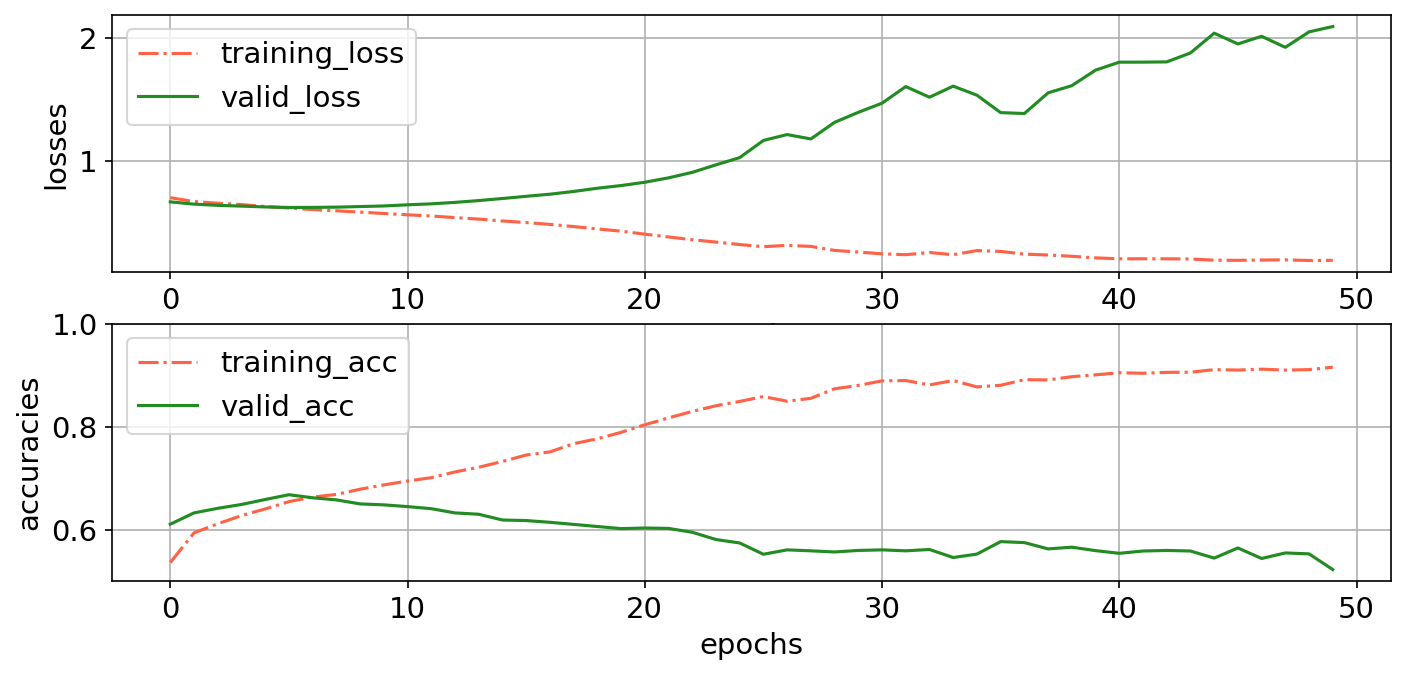

In [15]:
args.num_units = 32
model_file = f"{results_dir}/max/models/GRU_classifier_gruunits_{args.num_units}.pt"
history_file = f"{results_dir}/max/models/GRU_classifier_gruunits_{args.num_units}_history"

model = GRU_classifier(args).to(torch.float32)
loss_obj = nn.CrossEntropyLoss(ignore_index=args.MASK, reduction='mean')
optimizer = torch.optim.Adam(model.parameters())

model.to(device)
loss_obj.to(device)

# X_train, y_train, X_valid, y_valid, model_file, history_file
permut_train = torch.randperm(X_train.size()[0])
permut_valid = torch.randperm(X_valid.size()[0])

if not os.path.exists(model_file):
    fit(model, loss_obj, optimizer)


model.load_state_dict(torch.load(model_file))
with open(history_file, 'rb') as f:
    history = pickle.load(f)

plot_training_history(history)

print(evaluate(model, X_valid, y_valid, loss_obj, permut_valid))

permut_test = torch.randperm(X_test.size()[0])
print(evaluate(model, X_test, y_test, loss_obj, permut_test))